In [3]:
import pandas as pd

# 定义文件路径
file_path = r'D:\微量元素与图神经网络\微量元素与图神经网络\MIMIC心梗PCI术后生存实验室数据.xlsx'

# 加载Excel文件
data = pd.read_excel(file_path)

# 计算每列的缺失百分比
missing_percentages = data.isnull().mean() * 100

# 打印每列的缺失百分比
print("每列的缺失百分比：")
print(missing_percentages)




每列的缺失百分比：
subject_id                               0.000000
hadm_id                                  0.000000
admittime                                0.000000
dischtime                                0.000000
procedure_date                           0.000000
death_date                              62.776059
stay_days                                0.000000
survival_days                           62.776059
in_hospital_death                        0.000000
death_28_days                            0.000000
death_30_days                            0.000000
death_90_days                            0.000000
death_365_days                           0.000000
day                                      0.000000
hemoglobin_50811                        94.974928
sodium_50824                            97.898218
albumin_50862                           87.922757
alanine_aminotransferase_alt_50861     100.000000
asparate_aminotransferase_ast_50878    100.000000
c_reactive_protein_50889               1

In [1]:
import pandas as pd

# 定义文件路径
file_path = r'D:\微量元素与图神经网络\微量元素与图神经网络\MIMIC心梗PCI术后生存实验室数据.xlsx'

# 加载Excel文件
data = pd.read_excel(file_path)

# 计算唯一的 hadm_id 数量
unique_hadm_id_count = data['hadm_id'].nunique()

# 打印结果
print(f"唯一的 hadm_id 数量为: {unique_hadm_id_count}")


唯一的 hadm_id 数量为: 1095


In [5]:
import pandas as pd
import numpy as np

def process_mimic_data(
    input_path: str,
    output_path: str,
    missing_threshold: float = 20.0
) -> pd.DataFrame:
    """
    处理“MIMIC心梗PCI术后生存实验室数据.xlsx”数据集。

    逻辑:
      1) 读取Excel文件。
      2) 删除不需要的列: 'subject_id', 'admittime', 'dischtime', 'in_hospital_death', 'stay_days', 'survival_days'。
      3) 根据 'procedure_date' 和 'death_date' 计算事件和时间:
         - 如果 death_date 存在且 (death_date - procedure_date).days < 180:
             event=1, time=(death_date - procedure_date).days
         - 否则:
             event=0, time=180
      4) 删除 'procedure_date' 和 'death_date' 列。
      5) 根据 'hadm_id' 和 'day' 生成 'day_number'，并删除 'day' 列。
      6) 计算每列缺失百分比，删除缺失率 > 20%的列，但保留核心列:
         'hadm_id', 'event', 'time', 'day_number', 
         'death_28_days', 'death_30_days', 'death_90_days', 'death_365_days'
      7) 筛选出拥有至少三天数据的 'hadm_id'，并仅保留 'day_number' <= 3 的数据。
      8) 导出处理后的数据到指定的Excel文件。

    Parameters
    ----------
    input_path : str
        原始Excel文件路径。
    output_path : str
        处理后导出Excel文件路径。
    missing_threshold : float, optional
        缺失值超过此百分比的列将被删除。默认20.0%。

    Returns
    -------
    pd.DataFrame
        清洗后的DataFrame。
    """

    # ===================== 1. 读取Excel文件 =====================
    print(f"读取数据：{input_path}")
    df = pd.read_excel(input_path)
    print("\n原始数据基本信息：")
    print(df.info())

    # ===================== 2. 删除不需要的列 =====================
    cols_to_drop_initial = [
        'subject_id',
        'admittime',
        'dischtime',
        'in_hospital_death',
        'stay_days',
        'survival_days'
    ]
    df = df.drop(columns=cols_to_drop_initial, errors='ignore')
    print(f"\n已删除列: {cols_to_drop_initial}")

    # ===================== 3. 计算事件和时间 =====================
    required_cols = ['procedure_date', 'death_date']
    for col in required_cols:
        if col not in df.columns:
            print(f"错误: 缺少列 '{col}', 无法计算事件和时间。")
            return df
        # 转换为datetime
        df[col] = pd.to_datetime(df[col], errors='coerce')

    # 初始化 'event' 和 'time' 列
    df['event'] = 0
    df['time'] = 180

    # 计算天数差
    mask_death_valid = df['death_date'].notnull() & (df['death_date'] >= df['procedure_date'])
    days_diff = (df.loc[mask_death_valid, 'death_date'] - df.loc[mask_death_valid, 'procedure_date']).dt.days

    # 条件: 0 <= days_diff < 180
    mask_death_lt180 = mask_death_valid & (days_diff < 180)
    df.loc[mask_death_lt180, 'event'] = 1
    df.loc[mask_death_lt180, 'time'] = days_diff[mask_death_lt180].astype(int)

    # 处理 death_date < procedure_date 的情况 (设为 event=0, time=180)
    # 因为 death_date >= procedure_date 已经在 mask_death_valid 中定义，
    # 所以不需要单独处理 days_diff <0 的情况
    # 其它 cases: event=0, time=180

    # ===================== 4. 删除 'procedure_date' 和 'death_date' 列 =====================
    df = df.drop(columns=['procedure_date', 'death_date'], errors='ignore')
    print("\n已删除 'procedure_date' 和 'death_date' 列。")

    # ===================== 5. 生成 'day_number' 并删除 'day' 列 =====================
    if 'day' not in df.columns:
        print("错误: 'day' 列不存在，无法生成 'day_number'。")
        return df

    # 转换 'day' 为 datetime，并去除时区
    df['day'] = pd.to_datetime(df['day'], errors='coerce')
    if df['day'].dt.tz is not None:
        df['day'] = df['day'].dt.tz_convert(None)

    # 按 'hadm_id' 和 'day' 排序，生成 'day_number'
    df = df.sort_values(by=['hadm_id', 'day']).reset_index(drop=True)
    df['day_number'] = df.groupby('hadm_id')['day'].cumcount() + 1

    # 删除 'day' 列
    df = df.drop(columns=['day'], errors='ignore')
    print("\n已生成 'day_number' 并删除 'day' 列。")

    # ===================== 6. 删除缺失率 > 20% 的列 =====================
    essential_cols = [
        'hadm_id',
        'event',
        'time',
        'day_number',
        'death_28_days',
        'death_30_days',
        'death_90_days',
        'death_365_days'
    ]
    # 计算每列缺失率
    missing_percent = df.isnull().mean() * 100
    # 选择缺失率 <=20%的列
    cols_to_keep = missing_percent[missing_percent <= missing_threshold].index.tolist()
    # 确保核心列被保留
    final_keep = list(set(cols_to_keep) | set(essential_cols))
    # 筛选数据
    filtered_data = df[final_keep].copy()

    # 打印被删除的列
    dropped_cols = list(set(df.columns) - set(final_keep))
    if dropped_cols:
        print(f"\n以下列因缺失率 > {missing_threshold}% 已被删除：{dropped_cols}")
    else:
        print("\n没有列因缺失率超过阈值而被删除。")

    # ===================== 7. 筛选拥有至少三天数据的 'hadm_id' 并仅保留前三天 =====================
    hadm_counts = filtered_data['hadm_id'].value_counts()
    hadm_ids_with_3days = hadm_counts[hadm_counts >= 3].index.tolist()
    filtered_data = filtered_data[filtered_data['hadm_id'].isin(hadm_ids_with_3days)].copy()
    filtered_data = filtered_data[filtered_data['day_number'] <= 3].copy()
    print(f"\n已筛选出拥有至少三天数据的 'hadm_id' 数量: {len(hadm_ids_with_3days)}")
    print("并仅保留前三天的数据。")

    # ===================== 8. 导出处理后的数据 =====================
    print("\n处理后数据基本信息：")
    print(filtered_data.info())

    print("\n处理后数据示例：")
    print(filtered_data.head())

    try:
        filtered_data.to_excel(output_path, index=False)
        print(f"\n处理后的数据已成功导出至: {output_path}")
    except Exception as e:
        print(f"\n导出数据时发生错误: {e}")

    return filtered_data

if __name__ == "__main__":
    input_file = r"D:\微量元素与图神经网络\微量元素与图神经网络\MIMIC心梗PCI术后生存实验室数据.xlsx"
    output_file = r"D:\微量元素与图神经网络\微量元素与图神经网络\MIMIC_processed_survival_data.xlsx"

    df_final = process_mimic_data(input_file, output_file, missing_threshold=20.0)


读取数据：D:\微量元素与图神经网络\微量元素与图神经网络\MIMIC心梗PCI术后生存实验室数据.xlsx

原始数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9373 entries, 0 to 9372
Data columns (total 57 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   subject_id                           9373 non-null   int64         
 1   hadm_id                              9373 non-null   int64         
 2   admittime                            9373 non-null   datetime64[ns]
 3   dischtime                            9373 non-null   datetime64[ns]
 4   procedure_date                       9373 non-null   datetime64[ns]
 5   death_date                           3489 non-null   datetime64[ns]
 6   stay_days                            9373 non-null   int64         
 7   survival_days                        3489 non-null   float64       
 8   in_hospital_death                    9373 non-null   int64         
 9   death_28_days      

In [6]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# 1. 读取处理后的Excel文件
input_path = r'D:\微量元素与图神经网络\微量元素与图神经网络\MIMIC_processed_survival_data.xlsx'
data = pd.read_excel(input_path)

# 显示数据的基本信息
print("读取的数据基本信息：")
print(data.info())

# 2. 确认 'day_number' 列存在
if 'day_number' not in data.columns:
    print("错误：'day_number' 列不存在。请检查前面的数据处理步骤。")
else:
    print("'day_number' 列已存在。")

# 3. 识别需要插补的特征列
# 排除 'hadm_id', 'event', 'time', 'day_number' 以及 'death_*' 列
identifier_cols = ['hadm_id', 'event', 'time', 'day_number']
death_cols = ['death_28_days', 'death_30_days', 'death_90_days', 'death_365_days']
exclude_cols = identifier_cols + death_cols

feature_cols = [col for col in data.columns if col not in exclude_cols]

print(f"\n需要插补的特征列数量：{len(feature_cols)}")
print(f"特征列示例：{feature_cols[:5]}")

# 4. 检查是否存在非数值型的特征列
non_numeric_cols = data[feature_cols].select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_cols:
    print(f"\n警告：存在非数值型的特征列，将被排除在插补之外：{non_numeric_cols}")
    # 排除非数值型列
    feature_cols = [col for col in feature_cols if col not in non_numeric_cols]
else:
    print("\n所有特征列均为数值型。")

# 5. 提取需要插补的特征数据
features = data[feature_cols]

# 6. 初始化 KNNImputer
imputer = KNNImputer(n_neighbors=5, weights="uniform")

# 7. 应用 KNN 插补
imputed_features = imputer.fit_transform(features)

# 8. 将插补后的数据转换为 DataFrame，并设置列名
imputed_features_df = pd.DataFrame(imputed_features, columns=feature_cols)

# 9. 合并插补后的特征与标识列
# 保留标识列
identifiers = data[identifier_cols].reset_index(drop=True)
# 确保索引对齐
imputed_features_df = imputed_features_df.reset_index(drop=True)
final_data = pd.concat([identifiers, imputed_features_df], axis=1)

# 10. 确保没有带时区的 datetime 列（虽然 'day' 列已删除）
datetime_cols = final_data.select_dtypes(include=['datetimetz']).columns.tolist()
if datetime_cols:
    print(f"\n警告：存在带时区的 datetime 列: {datetime_cols}。将其转换为无时区。")
    for col in datetime_cols:
        final_data[col] = final_data[col].dt.tz_convert(None)

# 11. 检查 'day_number' 列是否存在并打印信息
if 'day_number' in final_data.columns:
    print("'day_number' 列已正确保留。")
else:
    print("错误：'day_number' 列不存在。请检查前面的数据处理步骤。")

# 12. 检查是否有任何剩余的带有时区的 datetime 列
datetime_cols = final_data.select_dtypes(include=['datetimetz']).columns.tolist()
if datetime_cols:
    print(f"警告：存在带时区的 datetime 列: {datetime_cols}。将其转换为无时区。")
    for col in datetime_cols:
        final_data[col] = final_data[col].dt.tz_convert(None)

# 13. 导出插补后的数据为新的Excel文件
output_path = r'D:\微量元素与图神经网络\微量元素与图神经网络\MIMIC_processed_survival_data_imputed.xlsx'
try:
    final_data.to_excel(output_path, index=False)
    print(f"\n插补后的完整数据已导出到 {output_path}")
except ValueError as e:
    print(f"导出数据时发生错误: {e}")

# 14. 打印前几行数据以验证
print("\n插补后的数据示例：")
print(final_data.head())

读取的数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3285 entries, 0 to 3284
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   chloride_50902         2645 non-null   float64
 1   hemoglobin_51222       2566 non-null   float64
 2   rdw_sd_52172           2562 non-null   float64
 3   death_30_days          3285 non-null   int64  
 4   rdw_51277              2562 non-null   float64
 5   sodium_50983           2651 non-null   float64
 6   death_90_days          3285 non-null   int64  
 7   red_blood_cells_51279  2562 non-null   float64
 8   event                  3285 non-null   int64  
 9   day_number             3285 non-null   int64  
 10  death_28_days          3285 non-null   int64  
 11  time                   3285 non-null   int64  
 12  creatinine_50912       2659 non-null   float64
 13  hadm_id                3285 non-null   int64  
 14  mchc_51249             2562 non-null   float6

数据概览:
    hadm_id  event  time  day_number  chloride_50902  hemoglobin_51222  \
0  20014999      0   180           1       102.10738         11.581751   
1  20014999      0   180           2       104.00000         12.100000   
2  20014999      0   180           3       100.50000         12.600000   
3  20035144      0   180           1       102.10738         11.581751   
4  20035144      0   180           2       109.00000          8.400000   

   rdw_sd_52172  rdw_51277  sodium_50983  red_blood_cells_51279  \
0     47.333627  14.235791    138.437277               3.894364   
1     46.100000  12.900000    138.000000               3.730000   
2     46.100000  12.700000    136.500000               3.800000   
3     47.333627  14.235791    138.437277               3.894364   
4     50.400000  16.966667    141.000000               3.046667   

   creatinine_50912  mchc_51249   mcv_51250  platelet_count_51265  
0          1.561195   32.578883   91.636544            211.763000  
1         

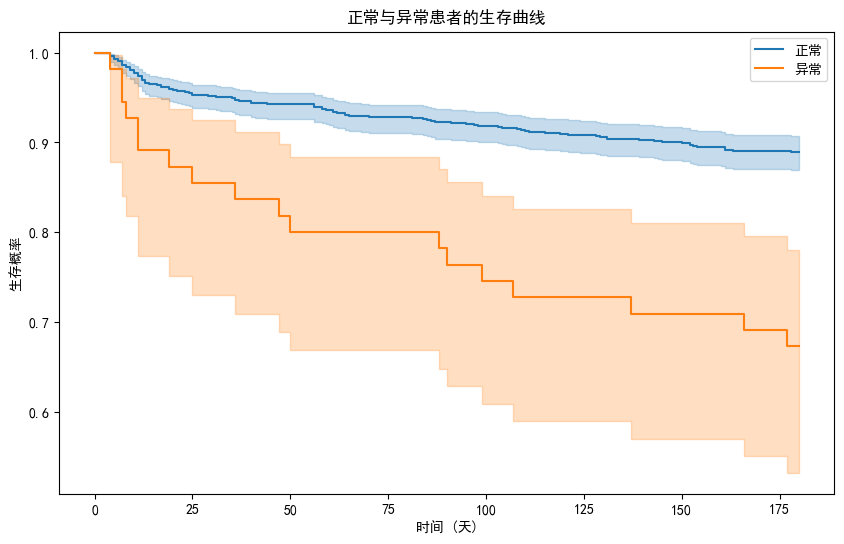


Log-Rank 检验结果：
p值: 3.9282869902947357e-07

生存曲线图已保存到: D:\微量元素与图神经网络\微量元素与图神经网络\survival_curve_normal_vs_anomalous.png


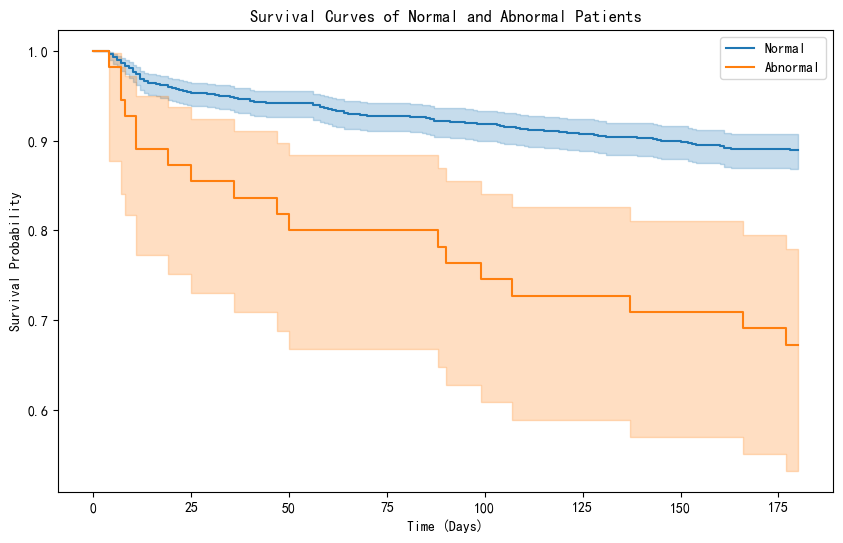

In [2]:
# ==========================
# 1. 导入必要的库
# ==========================
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import os

# 设置中文字体（例如 SimHei）以支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

# ==========================
# 2. 数据加载与预处理
# ==========================

# 定义文件路径
data_path = r'D:\微量元素与图神经网络\微量元素与图神经网络\MIMIC_processed_survival_data_imputed.xlsx'

# 读取Excel文件
data = pd.read_excel(data_path)

# 查看数据基本信息
print("数据概览:")
print(data.head())
print("\n数据描述:")
print(data.describe())
print("\n数据类型:")
print(data.dtypes)

# ==========================
# 3. 提取实验室项目列
# ==========================

# 排除的列
exclude_cols = [
    'hadm_id', 
    'event', 
    'time', 
    'day_number',
    'death_28_days', 
    'death_30_days', 
    'death_90_days', 
    'death_365_days'
]

# 提取实验室项目列
feature_cols = [col for col in data.columns if col not in exclude_cols]

print(f"\n提取的实验室项目列数量：{len(feature_cols)}")
print(f"实验室项目列示例：{feature_cols[:5]}")

# 确保所有特征列为数值型
data[feature_cols] = data[feature_cols].apply(pd.to_numeric, errors='coerce')

# ==========================
# 4. 构建滑动窗口特征
# ==========================

# 定义滑动窗口大小
window_size = 2  # 2天滑动窗口

# 初始化一个空的列表来存储窗口特征
window_features = []

# 获取唯一的患者编号
unique_ids = data['hadm_id'].unique()

# 遍历每个患者
for uid in unique_ids:
    patient_data = data[data['hadm_id'] == uid].sort_values('day_number')
    patient_data = patient_data.reset_index(drop=True)
    num_days = patient_data.shape[0]

    # 对每个检测项目应用滑动窗口
    for project in feature_cols:
        project_values = patient_data[project].values

        # 创建滑动窗口
        for i in range(num_days - window_size + 1):
            window = project_values[i:i + window_size]
            day1, day2 = window

            # 计算特征
            change = day2 - day1
            mean_val = np.mean(window)
            var_val = np.var(window)

            # 对应的住院日序号（窗口的第二天）
            hospital_day = patient_data.loc[i + window_size - 1, 'day_number']

            # 存储特征
            window_features.append({
                'hadm_id': uid,
                'day_number': hospital_day,
                '检测项目': project,
                'change': change,
                'mean_val': mean_val,
                'var_val': var_val
            })

# 转换为DataFrame
features_df = pd.DataFrame(window_features)

print("\n滑动窗口特征数据概览:")
print(features_df.head())
print("\n滑动窗口特征数据描述:")
print(features_df.describe())

# ==========================
# 5. 特征标准化
# ==========================

# 选择特征
feature_columns = ['change', 'mean_val', 'var_val']

# 提取特征矩阵
X = features_df[feature_columns].values

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==========================
# 6. 训练孤立森林模型并计算异常分数
# ==========================

# 训练孤立森林模型
iso_model = IsolationForest(n_estimators=100, contamination='auto', random_state=123)
iso_model.fit(X_scaled)

# 计算异常分数
# IsolationForest的decision_function返回的分数：越高越正常，越低越异常
# 通过取相反数使得异常分数越高越异常
anomaly_scores = -iso_model.decision_function(X_scaled)

# 添加异常分数到DataFrame
features_df['anomaly_score'] = anomaly_scores

# ==========================
# 7. 标准化异常分数
# ==========================

# 使用MinMaxScaler将异常分数缩放到[0,1]
scaler_score = MinMaxScaler()
features_df['anomaly_score_normalized'] = scaler_score.fit_transform(features_df[['anomaly_score']])

print("\n标准化后的异常分数数据概览:")
print(features_df[['hadm_id', 'day_number', '检测项目', 'anomaly_score', 'anomaly_score_normalized']].head())

# ==========================
# 8. 聚合异常分数（每位患者每一天的异常分数）
# ==========================

# 聚合每位患者每一天的异常分数，取平均值
patient_day_anomaly = features_df.groupby(['hadm_id', 'day_number'])['anomaly_score_normalized'].mean().reset_index()

# ==========================
# 9. 标记异常点
# ==========================

# 设置异常分数阈值为95%分位数
threshold = patient_day_anomaly['anomaly_score_normalized'].quantile(0.95)

# 标记异常
patient_day_anomaly['anomaly_label'] = patient_day_anomaly['anomaly_score_normalized'].apply(lambda x: '异常' if x > threshold else '正常')

print(f"\n异常分数阈值（95%分位数）: {threshold}")
print(f"异常点数量: {patient_day_anomaly['anomaly_label'].value_counts().get('异常', 0)}")
print(f"正常点数量: {patient_day_anomaly['anomaly_label'].value_counts().get('正常', 0)}")

# ==========================
# 10. 聚合异常标签到患者级别
# ==========================

# 按照 hadm_id 聚合异常分数（取平均）
patient_anomaly = patient_day_anomaly.groupby('hadm_id')['anomaly_score_normalized'].mean().reset_index()

# 设置异常分数阈值为95%分位数
threshold_patient = patient_anomaly['anomaly_score_normalized'].quantile(0.95)

# 标记异常和正常
patient_anomaly['label'] = patient_anomaly['anomaly_score_normalized'].apply(lambda x: '异常' if x > threshold_patient else '正常')

print(f"\n患者级别异常分数阈值（95%分位数）: {threshold_patient}")
print(f"异常患者数量: {patient_anomaly['label'].value_counts().get('异常', 0)}")
print(f"正常患者数量: {patient_anomaly['label'].value_counts().get('正常', 0)}")

# ==========================
# 11. 合并异常标签与生存分析信息
# ==========================

# 选择必要的列进行合并
survival_info = data[['hadm_id', 'event', 'time']].drop_duplicates()

# 合并标签
merged_data = pd.merge(survival_info, patient_anomaly[['hadm_id', 'label']], on='hadm_id', how='left')

print("\n合并后的数据示例：")
print(merged_data.head())

# ==========================
# 12. 生存曲线分析
# ==========================

# 分组
group_normal = merged_data[merged_data['label'] == '正常']
group_anomalous = merged_data[merged_data['label'] == '异常']

# 初始化 KaplanMeierFitter
kmf = KaplanMeierFitter()

# 绘制生存曲线
plt.figure(figsize=(10, 6))

# 适配生存曲线
kmf.fit(durations=group_normal['time'], event_observed=group_normal['event'], label='正常')
ax = kmf.plot_survival_function(ci_show=True)

kmf.fit(durations=group_anomalous['time'], event_observed=group_anomalous['event'], label='异常')
kmf.plot_survival_function(ax=ax, ci_show=True)

# 添加标题和标签
plt.title('正常与异常患者的生存曲线')
plt.xlabel('时间 (天)')
plt.ylabel('生存概率')

# 添加图例
plt.legend()

# 显示图形
plt.show()

# ==========================
# 13. 统计检验
# ==========================

# 进行Log-Rank检验
results = logrank_test(
    group_normal['time'], 
    group_anomalous['time'],
    event_observed_A=group_normal['event'],
    event_observed_B=group_anomalous['event']
)

print("\nLog-Rank 检验结果：")
print(f"p值: {results.p_value}")


# ==========================
# 14. 保存生存曲线图
# ==========================

# 定义保存目录
save_dir = r'D:\微量元素与图神经网络\微量元素与图神经网络'

# 确保保存目录存在
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 保存生存曲线图为高分辨率的PNG文件
survival_plot_save_path = os.path.join(save_dir, 'survival_curve_normal_vs_anomalous.png')

plt.figure(figsize=(10, 6))

# 重新绘制生存曲线以保存
kmf.fit(durations=group_normal['time'], event_observed=group_normal['event'], label='Normal')
ax = kmf.plot_survival_function(ci_show=True)

kmf.fit(durations=group_anomalous['time'], event_observed=group_anomalous['event'], label='Abnormal')
kmf.plot_survival_function(ax=ax, ci_show=True)

plt.title('Survival Curves of Normal and Abnormal Patients')
plt.xlabel('Time (Days)')
plt.ylabel('Survival Probability')
plt.legend()

# 保存图像
plt.savefig(survival_plot_save_path, dpi=300)
print(f"\n生存曲线图已保存到: {survival_plot_save_path}")

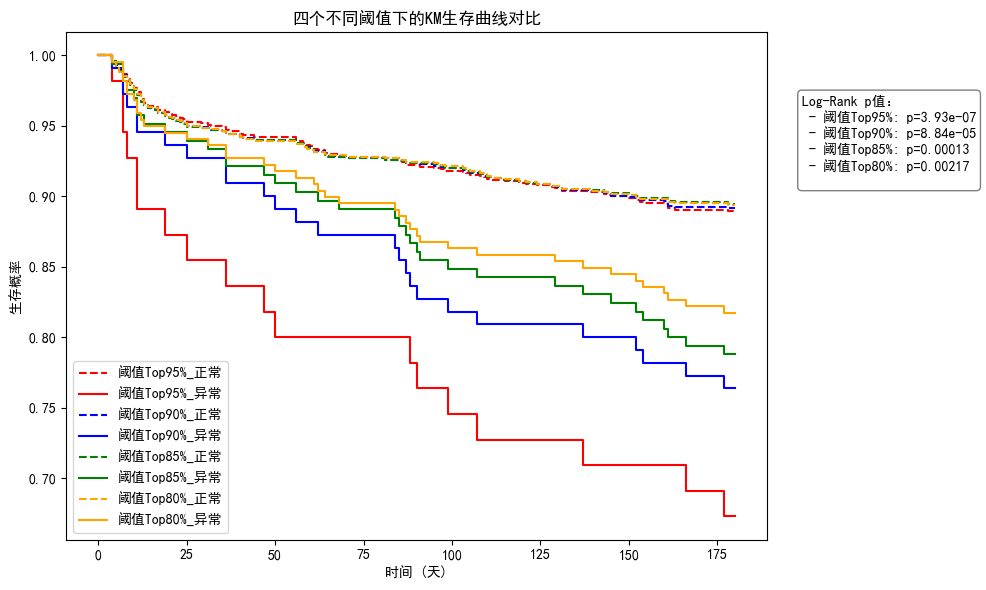

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import os

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

# ==========================
# 1. 数据加载与预处理 (保持与你现有代码一致)
# ==========================
data_path = r'D:\微量元素与图神经网络\微量元素与图神经网络\MIMIC_processed_survival_data_imputed.xlsx'
data = pd.read_excel(data_path)

exclude_cols = [
    'hadm_id', 
    'event', 
    'time', 
    'day_number',
    'death_28_days', 
    'death_30_days', 
    'death_90_days', 
    'death_365_days'
]
feature_cols = [col for col in data.columns if col not in exclude_cols]
data[feature_cols] = data[feature_cols].apply(pd.to_numeric, errors='coerce')

# ==========================
# 2. 构建滑动窗口特征 (保持不变)
# ==========================
window_size = 2
window_features = []
unique_ids = data['hadm_id'].unique()

for uid in unique_ids:
    patient_data = data[data['hadm_id'] == uid].sort_values('day_number').reset_index(drop=True)
    num_days = patient_data.shape[0]

    for project in feature_cols:
        project_values = patient_data[project].values
        for i in range(num_days - window_size + 1):
            window = project_values[i:i + window_size]
            day1, day2 = window

            change = day2 - day1
            mean_val = np.mean(window)
            var_val = np.var(window)

            hospital_day = patient_data.loc[i + window_size - 1, 'day_number']
            window_features.append({
                'hadm_id': uid,
                'day_number': hospital_day,
                '检测项目': project,
                'change': change,
                'mean_val': mean_val,
                'var_val': var_val
            })

features_df = pd.DataFrame(window_features)

# ==========================
# 3. 特征标准化 & 孤立森林
# ==========================
feature_columns = ['change', 'mean_val', 'var_val']
X_scaled = StandardScaler().fit_transform(features_df[feature_columns].values)

iso_model = IsolationForest(n_estimators=100, contamination='auto', random_state=123)
iso_model.fit(X_scaled)

# 计算异常分数并标准化
anomaly_scores = -iso_model.decision_function(X_scaled)
features_df['anomaly_score'] = anomaly_scores
features_df['anomaly_score_normalized'] = MinMaxScaler().fit_transform(
    features_df[['anomaly_score']]
)

# ==========================
# 4. 聚合到 (患者-天) 级别 & 获取生存信息
# ==========================
patient_day_anomaly = features_df.groupby(['hadm_id', 'day_number'])['anomaly_score_normalized'].mean().reset_index()
survival_info = data[['hadm_id', 'event', 'time']].drop_duplicates()

# ==========================
# 5. 不同阈值 + 合并一张图
# ==========================
quantiles = [0.95, 0.90, 0.85, 0.80]  # 对应 5%、10%、15%、20%

# 为了更好地区分曲线，给4个阈值定义不同的颜色/线型
# 这里仅示例，如果想更多区分，也可设置 8 种格式(4阈值×2组)
colors = ['red', 'blue', 'green', 'orange']   # 四个阈值对应颜色
line_styles = {
    'normal': '--',   # 正常组线型
    'anomaly': '-'    # 异常组线型
}

plt.figure(figsize=(10, 6))

# 存储一下 log-rank 的 p 值，用于在图例中显示
p_values = []

for i, q in enumerate(quantiles):
    # ========== 1) 分位数阈值 ==========
    # （先在“患者天”层面分完类，再聚合到患者级别）
    threshold_daily = patient_day_anomaly['anomaly_score_normalized'].quantile(q)
    temp_daily = patient_day_anomaly.copy()
    temp_daily['anomaly_label'] = temp_daily['anomaly_score_normalized'].apply(
        lambda x: '异常' if x > threshold_daily else '正常'
    )
    
    # ========== 2) 聚合到患者级别 (取每天平均分数) ==========
    patient_anomaly = temp_daily.groupby('hadm_id')['anomaly_score_normalized'].mean().reset_index()
    threshold_patient = patient_anomaly['anomaly_score_normalized'].quantile(q)
    patient_anomaly['label'] = patient_anomaly['anomaly_score_normalized'].apply(
        lambda x: '异常' if x > threshold_patient else '正常'
    )

    # ========== 3) 合并生存信息 ==========
    merged_data = pd.merge(survival_info, patient_anomaly[['hadm_id', 'label']],
                           on='hadm_id', how='left')

    # ========== 4) 分组 + KM 拟合 ==========
    group_normal = merged_data[merged_data['label'] == '正常']
    group_anomalous = merged_data[merged_data['label'] == '异常']

    kmf_normal = KaplanMeierFitter()
    kmf_anomaly = KaplanMeierFitter()

    # 拟合正常组
    kmf_normal.fit(
        durations=group_normal['time'],
        event_observed=group_normal['event']
    )

    # 拟合异常组
    kmf_anomaly.fit(
        durations=group_anomalous['time'],
        event_observed=group_anomalous['event']
    )

    # ========== 5) 绘图(叠加到同一张) ==========
    # 颜色根据 i 来取，线型用 line_styles 来区分
    # label 中加上阈值和组别
    label_normal = f'阈值Top{int(q*100)}%_正常'
    label_anomaly = f'阈值Top{int(q*100)}%_异常'

    kmf_normal.plot_survival_function(
        ci_show=False,
        ax=plt.gca(),
        color=colors[i],
        linestyle=line_styles['normal'],
        label=label_normal
    )
    kmf_anomaly.plot_survival_function(
        ci_show=False,
        ax=plt.gca(),
        color=colors[i],
        linestyle=line_styles['anomaly'],
        label=label_anomaly
    )

    # ========== 6) Log-Rank 检验 + 记录 p 值 ==========
    results = logrank_test(
        group_normal['time'],
        group_anomalous['time'],
        event_observed_A=group_normal['event'],
        event_observed_B=group_anomalous['event']
    )
    p_values.append((q, results.p_value))

# ========== 图形整体美化和p值提示 ==========
plt.title('四个不同阈值下的KM生存曲线对比')
plt.xlabel('时间 (天)')
plt.ylabel('生存概率')
plt.legend()

# 在图上加一个文本，列出每个阈值对应的p值 (可根据需求调整位置或美化)
text_p = "Log-Rank p值：\n"
for (q, pv) in p_values:
    text_p += f" - 阈值Top{int(q*100)}%: p={pv:.3g}\n"

# 这里在右上角加一个文本框，你也可以自定义坐标
plt.text(
    1.05, 0.7, text_p,
    transform=plt.gca().transAxes,    # 使用坐标轴的相对位置
    fontsize=10,
    bbox=dict(boxstyle="round", fc="w", ec="gray")
)

plt.tight_layout()
plt.show()

# ========== 如果需要保存图像 ==========
# save_dir = r'D:\微量元素与图神经网络\微量元素与图神经网络'
# plt.savefig(os.path.join(save_dir, 'survival_curve_all_in_one.png'), dpi=300)
# plt.close()




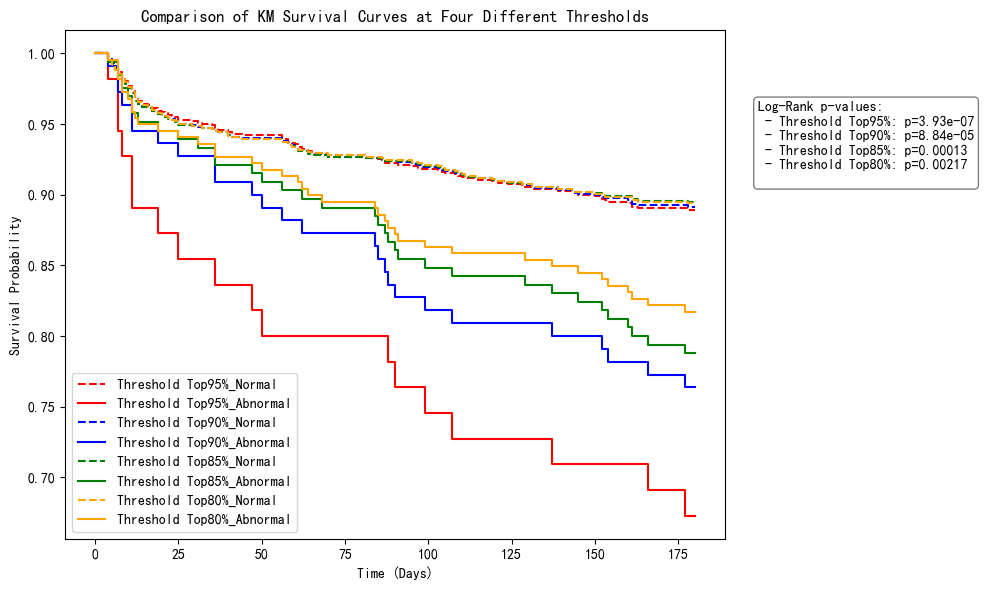

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import os

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

# ==========================
# 1. 数据加载与预处理 (保持与你现有代码一致)
# ==========================
data_path = r'D:\微量元素与图神经网络\微量元素与图神经网络\MIMIC_processed_survival_data_imputed.xlsx'
data = pd.read_excel(data_path)

exclude_cols = [
    'hadm_id', 
    'event', 
    'time', 
    'day_number',
    'death_28_days', 
    'death_30_days', 
    'death_90_days', 
    'death_365_days'
]
feature_cols = [col for col in data.columns if col not in exclude_cols]
data[feature_cols] = data[feature_cols].apply(pd.to_numeric, errors='coerce')

# ==========================
# 2. 构建滑动窗口特征 (保持不变)
# ==========================
window_size = 2
window_features = []
unique_ids = data['hadm_id'].unique()

for uid in unique_ids:
    patient_data = data[data['hadm_id'] == uid].sort_values('day_number').reset_index(drop=True)
    num_days = patient_data.shape[0]

    for project in feature_cols:
        project_values = patient_data[project].values
        for i in range(num_days - window_size + 1):
            window = project_values[i:i + window_size]
            day1, day2 = window

            change = day2 - day1
            mean_val = np.mean(window)
            var_val = np.var(window)

            hospital_day = patient_data.loc[i + window_size - 1, 'day_number']
            window_features.append({
                'hadm_id': uid,
                'day_number': hospital_day,
                '检测项目': project,
                'change': change,
                'mean_val': mean_val,
                'var_val': var_val
            })

features_df = pd.DataFrame(window_features)

# ==========================
# 3. 特征标准化 & 孤立森林
# ==========================
feature_columns = ['change', 'mean_val', 'var_val']
X_scaled = StandardScaler().fit_transform(features_df[feature_columns].values)

iso_model = IsolationForest(n_estimators=100, contamination='auto', random_state=123)
iso_model.fit(X_scaled)

# 计算异常分数并标准化
anomaly_scores = -iso_model.decision_function(X_scaled)
features_df['anomaly_score'] = anomaly_scores
features_df['anomaly_score_normalized'] = MinMaxScaler().fit_transform(
    features_df[['anomaly_score']]
)

# ==========================
# 4. 聚合到 (患者-天) 级别 & 获取生存信息
# ==========================
patient_day_anomaly = features_df.groupby(['hadm_id', 'day_number'])['anomaly_score_normalized'].mean().reset_index()
survival_info = data[['hadm_id', 'event', 'time']].drop_duplicates()

# ==========================
# 5. 不同阈值 + 合并一张图
# ==========================
quantiles = [0.95, 0.90, 0.85, 0.80]  # 对应 5%、10%、15%、20%

# 为了更好地区分曲线，给4个阈值定义不同的颜色/线型
colors = ['red', 'blue', 'green', 'orange']   # 四个阈值对应颜色
line_styles = {
    'normal': '--',   # 正常组线型
    'anomaly': '-'    # 异常组线型
}

plt.figure(figsize=(10, 6))

# 存储一下 log-rank 的 p 值，用于在图例中显示
p_values = []

for i, q in enumerate(quantiles):
    # ========== 1) 分位数阈值 ==========
    threshold_daily = patient_day_anomaly['anomaly_score_normalized'].quantile(q)
    temp_daily = patient_day_anomaly.copy()
    temp_daily['anomaly_label'] = temp_daily['anomaly_score_normalized'].apply(
        lambda x: '异常' if x > threshold_daily else '正常'
    )
    
    # ========== 2) 聚合到患者级别 (取每天平均分数) ==========
    patient_anomaly = temp_daily.groupby('hadm_id')['anomaly_score_normalized'].mean().reset_index()
    threshold_patient = patient_anomaly['anomaly_score_normalized'].quantile(q)
    patient_anomaly['label'] = patient_anomaly['anomaly_score_normalized'].apply(
        lambda x: '异常' if x > threshold_patient else '正常'
    )

    # ========== 3) 合并生存信息 ==========
    merged_data = pd.merge(survival_info, patient_anomaly[['hadm_id', 'label']],
                           on='hadm_id', how='left')

    # ========== 4) 分组 + KM 拟合 ==========
    group_normal = merged_data[merged_data['label'] == '正常']
    group_anomalous = merged_data[merged_data['label'] == '异常']

    kmf_normal = KaplanMeierFitter()
    kmf_anomaly = KaplanMeierFitter()

    # 拟合正常组
    kmf_normal.fit(
        durations=group_normal['time'],
        event_observed=group_normal['event']
    )

    # 拟合异常组
    kmf_anomaly.fit(
        durations=group_anomalous['time'],
        event_observed=group_anomalous['event']
    )

    # ========== 5) 绘图(叠加到同一张) ==========
    # 颜色根据 i 来取，线型用 line_styles 来区分
    # label 中加上阈值和组别
    label_normal = f'Threshold Top{int(q*100)}%_Normal'
    label_anomaly = f'Threshold Top{int(q*100)}%_Abnormal'

    kmf_normal.plot_survival_function(
        ci_show=False,
        ax=plt.gca(),
        color=colors[i],
        linestyle=line_styles['normal'],
        label=label_normal
    )
    kmf_anomaly.plot_survival_function(
        ci_show=False,
        ax=plt.gca(),
        color=colors[i],
        linestyle=line_styles['anomaly'],
        label=label_anomaly
    )

    # ========== 6) Log-Rank 检验 + 记录 p 值 ==========
    results = logrank_test(
        group_normal['time'],
        group_anomalous['time'],
        event_observed_A=group_normal['event'],
        event_observed_B=group_anomalous['event']
    )
    p_values.append((q, results.p_value))

# ========== 图形整体美化和p值提示 ==========
plt.title('Comparison of KM Survival Curves at Four Different Thresholds')
plt.xlabel('Time (Days)')
plt.ylabel('Survival Probability')
plt.legend()

# 在图上加一个文本，列出每个阈值对应的p值 (可根据需求调整位置或美化)
text_p = "Log-Rank p-values:\n"
for (q, pv) in p_values:
    text_p += f" - Threshold Top{int(q*100)}%: p={pv:.3g}\n"

# 这里在右上角加一个文本框，你也可以自定义坐标
plt.text(
    1.05, 0.7, text_p,
    transform=plt.gca().transAxes,    # 使用坐标轴的相对位置
    fontsize=10,
    bbox=dict(boxstyle="round", fc="w", ec="gray")
)

plt.tight_layout()
plt.show()

# ========== 如果需要保存图像 ==========
# save_dir = r'D:\微量元素与图神经网络\微量元素与图神经网络'
# plt.savefig(os.path.join(save_dir, 'survival_curve_all_in_one.png'), dpi=300)
# plt.close()
